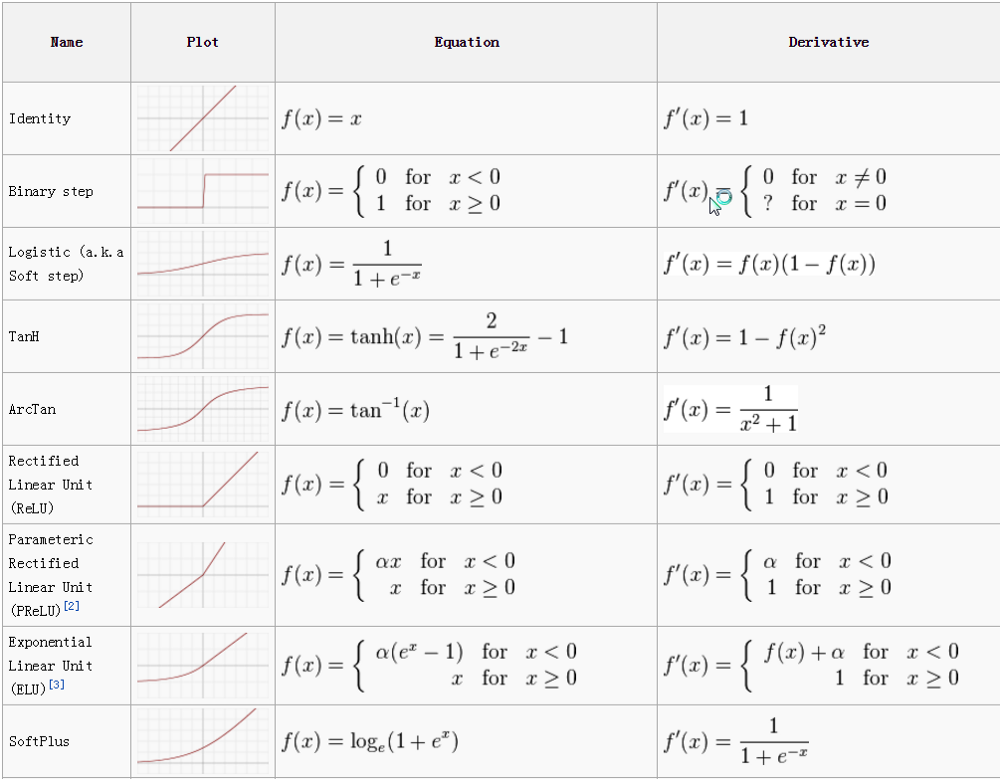

In [27]:
from IPython.display import Image
Image("D:\\강화학습\\스터디\\act_fun.png")

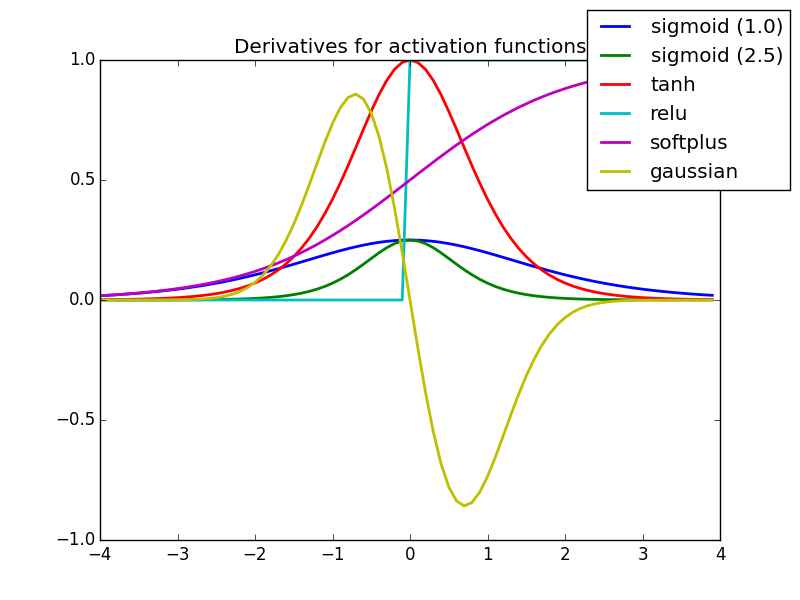

In [28]:
Image("D:\\강화학습\\스터디\\act_fun2.png")

In [1]:
import tensorflow as tf

# 공통
import numpy as np
import os

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
font_name = font_manager.FontProperties(fname = 'C:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family = font_name)

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "D:\\강화학습"
CHAPTER_ID = "스터디"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

C:\Users\xp102\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 일관된 출력을 위해 seed 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

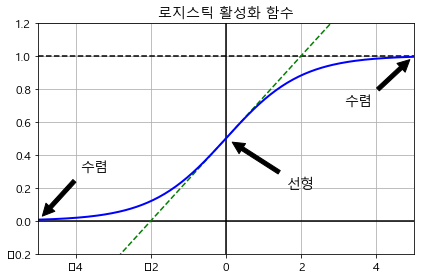

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('수렴', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('수렴', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('선형', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("로지스틱 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

### He 초기화

In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

### 수렴하지 않는 활성화 함수


#### Leaky ReLU

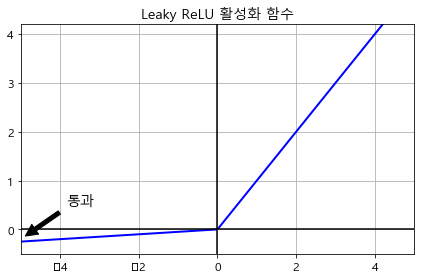

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('통과', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

텐서플로에서 Leaky ReLU 구현하기:

In [8]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.leaky_relu, name="hidden1")

Leaky ReLU를 사용하여 신경망을 훈련시켜 보자!!

먼저 그래프를 정의합니다:

In [9]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [10]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

데이터를 로드합니다:

In [11]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [12]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [14]:
n_epochs = 36
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "Vali 세트 정확도:", acc_valid)

0 배치 데이터 정확도: 0.92 Vali 세트 정확도: 0.9006
5 배치 데이터 정확도: 0.92 Vali 세트 정확도: 0.942
10 배치 데이터 정확도: 0.9 Vali 세트 정확도: 0.96
15 배치 데이터 정확도: 0.96 Vali 세트 정확도: 0.966
20 배치 데이터 정확도: 0.98 Vali 세트 정확도: 0.97
25 배치 데이터 정확도: 0.96 Vali 세트 정확도: 0.9742
30 배치 데이터 정확도: 1.0 Vali 세트 정확도: 0.9764
35 배치 데이터 정확도: 1.0 Vali 세트 정확도: 0.9762


### ELU

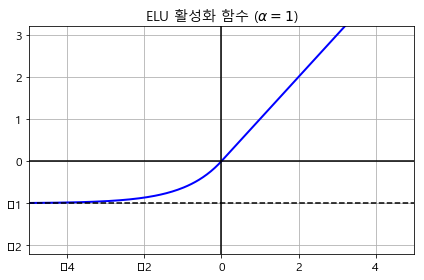

In [15]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.텐서플로에서 Leaky ReLU 구현하기:2], 'k-')
plt.grid(True)
plt.title(r"ELU 활성화 함수 ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 ELU 구현하기:

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

# SELU

이 활성화 함수는 Günter Klambauer, Thomas Unterthiner, Andreas Mayr가 2017년에 쓴 논문에서 소개되었습니다(나중에 책에 추가하겠습니다). 훈련할 때 SELU 활성화 함수를 사용한 완전 연결 신경망은 스스로 정규화를 합니다. 각 층의 출력은 훈련하는 동안 같은 평균과 분산을 유지하려는 경향이 있어 그래디언트 소실과 폭주 문제를 해결합니다. 이 활성화 함수는 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해봐야 합니다

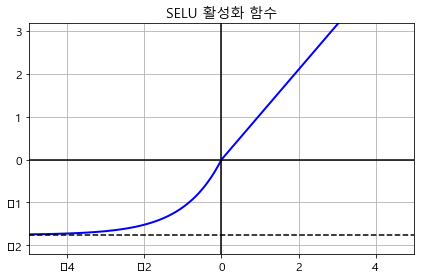

In [17]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

기본적으로 SELU 하이퍼파라미터(scale과 alpha)는 평균이 0, 표준 편차가 1에 가깝게 유지되도록 조정합니다(입력도 평균이 0, 표준 편차가 1로 표준화되었다고 가정합니다). 이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지합니다:

In [18]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("층 {}: {:.2f} < 평균 < {:.2f}, {:.2f} < 표준 편차 < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

층 0: -0.26 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 10: -0.24 < 평균 < 0.27, 0.74 < 표준 편차 < 1.27
층 20: -0.17 < 평균 < 0.18, 0.74 < 표준 편차 < 1.24
층 30: -0.27 < 평균 < 0.24, 0.78 < 표준 편차 < 1.20
층 40: -0.38 < 평균 < 0.39, 0.74 < 표준 편차 < 1.25
층 50: -0.27 < 평균 < 0.31, 0.73 < 표준 편차 < 1.27
층 60: -0.26 < 평균 < 0.43, 0.74 < 표준 편차 < 1.35
층 70: -0.19 < 평균 < 0.21, 0.75 < 표준 편차 < 1.21
층 80: -0.18 < 평균 < 0.16, 0.72 < 표준 편차 < 1.19
층 90: -0.19 < 평균 < 0.16, 0.75 < 표준 편차 < 1.20


하지만 SELU 활성화 함수는 일반적인 드롭아웃과 함께 사용할 수 없습니다(드롭아웃은 SELU 활성화 함수의 자동 정규화 기능을 없애버립니다). 다행히 같은 논문에 실린 알파 드롭아웃(Alpha Dropout)을 사용할 수 있습니다. 텐서플로 1.4에 tf.contrib.nn.alpha_dropout()이 추가되었습니다
(Linz 대학교 생물정보학 연구소(Institute of Bioinformatics)의 Johannes Kepler가 만든 구현을 확인해 보세요).

SELU 활성화 함수를 사용한 신경망을 만들어 MNIST 문제를 풀어 보겠습니다

In [19]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 36
batch_size = 50

이제 훈련할 차례입니다. 입력을 평균 0, 표준 편차 1로 스케일 조정해야 합니다:

In [20]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

0 배치 데이터 정확도: 0.92 검증 세트 정확도: 0.9232
5 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.956
10 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9646
15 배치 데이터 정확도: 0.94 검증 세트 정확도: 0.9692
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9702
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9716
30 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9728
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9718


## 배치 정규화

각 은닉층의 활성화 함수 전에 배치 정규화를 추가하기 위해 ELU 활성화 함수를 배치 정규화 층 이후에 수동으로 적용하겠습니다.

In [21]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

In [22]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(tf.layers.batch_normalization(hidden1))
    hidden2 = tf.layers.dense(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(tf.layers.batch_normalization(hidden2))
    logits_before_bn = tf.layers.dense(bn2, n_outputs, name="outputs")
    logits = tf.layers.batch_normalization(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
n_epochs = 36
batch_size = 50

In [24]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", accuracy_val)

0 배치 데이터 정확도: 0.14 검증 세트 정확도: 0.9066
5 배치 데이터 정확도: 0.12 검증 세트 정확도: 0.9412
10 배치 데이터 정확도: 0.24 검증 세트 정확도: 0.959
15 배치 데이터 정확도: 0.06 검증 세트 정확도: 0.9692
20 배치 데이터 정확도: 0.1 검증 세트 정확도: 0.971
25 배치 데이터 정확도: 0.06 검증 세트 정확도: 0.9734
30 배치 데이터 정확도: 0.1 검증 세트 정확도: 0.9742
35 배치 데이터 정확도: 0.76 검증 세트 정확도: 0.9736


어!? MNIST 정확도가?!?!??!?!?!? (왜.. 논문대로 안나올까여 SELU가 꼴찌입니다)

얕은 신경망에서는 배치 정규화와 ELU가 큰 효과를 내지 못한다고 합니다. 대부분 심층 신경망에서 빛을 발합니다.

## Summary

#### 1. Leaky_ReLu: 0.9762
#### 2. ELU + Batch_Norm: 0.9736
#### 3. SELU: 0.9718

깊은 신경망이라면, SELU를 시험해 봅시다!!